# Data processing

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import nltk

In [2]:

df = pd.read_csv('final.csv')

In [3]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'joint_tweets','fullname','id','lists'])
df = df.drop(df.index[[336]])####drop row

In [4]:
###remove data that has null values
data = df[df['twitter'].notnull()]

In [5]:
data_train = data[data['followers'].notnull()]
data_train = data_train[data_train['market_value'].notna()]

data_train.index = range(len(data_train))


In [6]:
###process height feature
data_train['height_ver2'] = data_train['height'].apply(lambda x: str(x).replace(',', '').replace('m', ''))


In [7]:
###contract start date 
data_train['join_date_ver1'] = data_train['join_date'].apply(lambda x: x if '20' in x else 0)####20 year

data_train['join_date_ver2'] = data_train['join_date_ver1'].apply(lambda x: (datetime.datetime.strptime("Dec31,2019", "%b%d,%Y").date() - datetime.datetime.strptime(x, "%b%d,%Y").date()).days/365 if x!=0  else 0)

In [8]:
###contract end date
data_train['exp_date_ver1'] = data_train['exp_date'].apply(lambda x: x if '20' in x else 0)

In [9]:
def date_change(x):
    try:
        ndays = (datetime.datetime.strptime(x, "%d.%m.%Y").date() - datetime.datetime.strptime("Dec31,2019", "%b%d,%Y").date()).days
    except:
        ndays = 0
    return ndays/365
        

In [10]:
data_train['exp_date_ver2'] = data_train['exp_date_ver1'].apply(date_change)

In [11]:
###data joined twitter feature
data_train['date_joined_twitter_ver1'] = data_train['date_joined'].apply(lambda x: str(x).replace('.', '').replace('-', '').replace('AM', '').replace('PM', '').replace(' ', ''))

In [12]:
def date_change_twitter(x):
    try:
        ndays = (datetime.datetime.strptime("Dec31,2019", "%b%d,%Y").date() - datetime.datetime.strptime(x, "%I:%M%d%b%Y").date()).days
    except:
        ndays = 0
    return ndays/365
data_train['date_joined_twitter_ver2'] = data_train['date_joined_twitter_ver1'].apply(date_change_twitter)

In [13]:
###market value, make units consistent
def value_trans(value):
    try:
        if 'm' in value:
            a1 = value.replace('$','').replace('m', '') 
        elif 'k' in value:
            a1 = float(value.replace('$','').replace('k', ''))/1000
    except:
        a1 = 0
    return float(a1)

data_train['market_value_ver2'] = data_train['market_value'].apply(value_trans)

In [14]:
###NUmber of Tropy

data_train['trophy_ver2'] = data_train['trophy'].apply(lambda x: 0 if np.isnan(float(x)) else x)

In [15]:
###identify the continent for each player

import pycountry
import pycountry_convert as pc
def country_to_continent(country_name):
    try:
        if country_name == 'DR Congo':
            country_continent_name = 'Africa'
        else:
            fuzzy = pycountry.countries.search_fuzzy(country_name)
            country_alpha2 = pc.country_name_to_country_alpha2(fuzzy[0].name)
            country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
            country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    except:
        country_continent_name = 'Europe'
    return country_continent_name

In [16]:
data_train['nationality_ver2'] = data_train['nationality'].apply(country_to_continent)


In [17]:
###player agent

data_train['Player_agent_ver2'] = data_train['Player_agent'].apply(lambda x : 0 if (x =='Relatives')|(x =='noagent ')|(x =='notclarified') else 1)


In [18]:
###sent score
data_train['sent_score'] = data_train['sent_mean']*data_train['sent_length']

In [19]:
###impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
 
imputer = IterativeImputer(max_iter=10, random_state=0)
 

duty_data = data_train[['height_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score', 'sent_max', 'sent_min', 'best', 'goal', 'good', 'great', 'love']] 

imputed_data= imputer.fit_transform(duty_data)
 
imp =imputer.fit_transform(duty_data)

In [20]:
imp_data = pd.DataFrame(imp, columns=['height_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score', 'sent_max', 'sent_min', 'best', 'goal', 'good', 'great', 'love'])

In [21]:
data_train['goals_ver2'] = data_train['goals'].apply(lambda x : x if x!='-' else 0)
data_train['Assists_ver2'] = data_train['Assists'].apply(lambda x : x if x!='-' else 0)
data_train['min_per_goal_ver2'] = data_train['min_per_goal'].apply(lambda x : x if x!='-' else 0)
data_train['injury_ver2'] = data_train['injury'].apply(lambda x : 0 if x=='0' else 1)

In [22]:
###reduce category of position

def position(info):
    if 'Forward' in info:
        info = 'Forward'
    elif 'Midfielder' in info:
        info = 'Midfielder'
    elif 'Defender' in info:
        info = 'Defender'
    elif 'Goalkeeper' in info:
        info = 'Goalkeeper'
    return info
data_train['position_ver2'] = data_train['Position'].apply(position )

In [23]:
###twitter data
data_train['appearance_ver2'] = data_train['appearance'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['minutes_ver2'] = data_train['minutes'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['num_tweets_ver2'] = data_train['num_tweets'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['following_ver2'] = data_train['following'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['followers_ver2'] = data_train['followers'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['likes_ver2'] = data_train['likes'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['date_joined_twitter_ver3'] = data_train['date_joined_twitter_ver2'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))

In [24]:
###left or right foot
data_train['Foot_ver2'] = data_train['Foot'].apply(lambda x : x if (x == 'left')|(x == 'right') else 'both')

In [25]:
###adidas or nike
data_train['outfitter_ver2'] = data_train['outfitter'].apply(lambda x : x if (x == 'Nike')|(x == 'adidas') else 'other')

In [26]:
dummies_foot = pd.get_dummies(data_train['Foot_ver2'], prefix= 'foot')
dummies_position = pd.get_dummies(data_train['position_ver2'], prefix= 'position')
dummies_outfitter = pd.get_dummies(data_train['outfitter_ver2'], prefix= 'outfitter')
dummies_nationality = pd.get_dummies(data_train['nationality_ver2'], prefix='nationality_ver2')

In [27]:
# data_train.sent_mean.loc[data_train.sent_mean.isnull()] = 0
# data_train.sent_max.loc[data_train.sent_max.isnull()] = 0
# data_train.sent_min.loc[data_train.sent_min.isnull()] = 0
# data_train.sent_length.loc[data_train.sent_length.isnull()] = 0
# data_train.best.loc[data_train.best.isnull()] = 0
# data_train.good.loc[data_train.good.isnull()] = 0
# data_train.great.loc[data_train.great.isnull()] = 0
# data_train.love.loc[data_train.love.isnull()] = 0

In [28]:
###save processed data
data_train.to_csv('data_train.csv')

In [29]:
data_train.columns

Index(['name', 'trophy', 'nationality', 'height', 'injury', 'startelfquote',
       'minutenquote', 'twitter', 'age', 'Position', 'Foot', 'Player_agent',
       'join_date', 'exp_date', 'exten_date', 'outfitter', 'club',
       'appearance', 'minutes', 'goals', 'Assists', 'min_per_goal',
       'market_value', 'sent_mean', 'sent_max', 'sent_min', 'sent_length',
       'best', 'goal', 'good', 'great', 'love', 'user', 'date_joined',
       'num_tweets', 'following', 'followers', 'likes', 'height_ver2',
       'join_date_ver1', 'join_date_ver2', 'exp_date_ver1', 'exp_date_ver2',
       'date_joined_twitter_ver1', 'date_joined_twitter_ver2',
       'market_value_ver2', 'trophy_ver2', 'nationality_ver2',
       'Player_agent_ver2', 'sent_score', 'goals_ver2', 'Assists_ver2',
       'min_per_goal_ver2', 'injury_ver2', 'position_ver2', 'appearance_ver2',
       'minutes_ver2', 'num_tweets_ver2', 'following_ver2', 'followers_ver2',
       'likes_ver2', 'date_joined_twitter_ver3', 'Foot_ver2',


In [30]:
###pick data that dont need scale or dummies
let1 = data_train[['age', 'injury_ver2','startelfquote', 'minutenquote','Player_agent_ver2', 'appearance_ver2', 'minutes_ver2',\
       'num_tweets_ver2', 'following_ver2', 'followers_ver2', 'likes_ver2',\
       'date_joined_twitter_ver3', 'goals_ver2', 'Assists_ver2', 'min_per_goal_ver2', 'market_value_ver2' ]]

In [31]:
final = pd.concat([imp_data, dummies_foot,dummies_position,dummies_outfitter,dummies_nationality, let1],axis=1)

In [32]:
final.shape

(1435, 43)

In [33]:
final.to_csv('final0204_orig.csv')

In [34]:
webapp_name = pd.DataFrame(data_train['name'], columns=['name'])

In [35]:
webapp_name.to_csv('webapp_name.csv')

In [36]:
webapp_name['first'] = webapp_name['name'].apply(lambda x : nltk.word_tokenize(x)[0])
webapp_name['last'] = webapp_name['name'].apply(lambda x : nltk.word_tokenize(x)[-1])

In [178]:
data_train[['name','sent_mean','best', 'goal', 'good', 'great', 'love']].loc[4:20]

,name,sent_mean,best,goal,good,great,love
4,Virgil van Dijk,0.207992,0.293952,0.093977,0.235847,0.147115,0.077014
5,Andy Lonergan,0.263456,0.227510,0.193962,0.278154,0.151816,0.317902
6,Leon Balogun,0.249531,0.170313,0.000000,0.117126,0.085237,0.267727
7,Andy Carroll,0.176070,0.166450,0.454099,0.152627,0.092559,0.155055
8,Scott McTominay,0.157368,0.195550,0.070609,0.073834,0.080597,0.096439
9,Martin Kelly,0.351732,0.000000,0.000000,0.167265,0.547757,0.191166
10,Nicolás Otamendi,0.175168,0.158265,0.026986,0.241869,0.264023,0.082929
11,Mason Mount,0.165926,0.042290,0.144216,0.168037,0.098770,0.118184
12,Mesut Özil,0.188063,0.176339,0.049201,0.220493,0.160460,0.184800
13,Marcus Rashford,0.200466,0.159108,0.073989,0.238736,0.159258,0.166742


# scale data

In [2]:
final = pd.read_csv('final0204_orig.csv')

In [3]:
ss = StandardScaler()
mm = MinMaxScaler()

In [4]:
final.columns

Index(['Unnamed: 0', 'height_ver2', 'join_date_ver2', 'exp_date_ver2',
       'sent_score', 'sent_max', 'sent_min', 'best', 'goal', 'good', 'great',
       'love', 'foot_both', 'foot_left', 'foot_right', 'position_Defender',
       'position_Forward', 'position_Goalkeeper', 'position_Midfielder',
       'outfitter_Nike', 'outfitter_adidas', 'outfitter_other',
       'nationality_ver2_Africa', 'nationality_ver2_Asia',
       'nationality_ver2_Europe', 'nationality_ver2_North America',
       'nationality_ver2_Oceania', 'nationality_ver2_South America', 'age',
       'injury_ver2', 'startelfquote', 'minutenquote', 'Player_agent_ver2',
       'appearance_ver2', 'minutes_ver2', 'num_tweets_ver2', 'following_ver2',
       'followers_ver2', 'likes_ver2', 'date_joined_twitter_ver3',
       'goals_ver2', 'Assists_ver2', 'min_per_goal_ver2', 'market_value_ver2'],
      dtype='object')

In [5]:
part1 = final[['best', 'goal', 'good', 'great',
       'love', 'foot_both', 'foot_left', 'foot_right', 'position_Defender',
       'position_Forward', 'position_Goalkeeper', 'position_Midfielder',
       'outfitter_Nike', 'outfitter_adidas', 'outfitter_other',
       'nationality_ver2_Africa', 'nationality_ver2_Asia',
       'nationality_ver2_Europe', 'nationality_ver2_North America',
       'nationality_ver2_Oceania', 'nationality_ver2_South America']]

In [6]:
part2 = final[['height_ver2','injury_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score', 'sent_max', 'sent_min', 'age',
       'startelfquote', 'minutenquote', 'Player_agent_ver2', 'appearance_ver2',
       'minutes_ver2', 'num_tweets_ver2', 'following_ver2', 'followers_ver2',
       'likes_ver2', 'date_joined_twitter_ver3', 'goals_ver2', 'Assists_ver2',
       'min_per_goal_ver2', 'market_value_ver2']]

In [7]:
part2_scaled = ss.fit_transform(part2)

In [8]:
final_data = np.concatenate((part1.to_numpy(), part2.astype('float', copy=False)), axis=1)

In [19]:
pl = final[['sent_score', 'sent_max', 'sent_min', 'best', 'goal', 'good', 'great',
       'love', 'foot_both', 'foot_left', 'foot_right', 'position_Defender',
       'position_Forward', 'position_Goalkeeper', 'position_Midfielder',
       'outfitter_Nike', 'outfitter_adidas', 'outfitter_other', 'age',
       'injury_ver2', 'startelfquote', 'minutenquote', 'Player_agent_ver2',
       'appearance_ver2', 'minutes_ver2', 'num_tweets_ver2', 'following_ver2',
       'followers_ver2', 'likes_ver2', 'date_joined_twitter_ver3',
       'goals_ver2', 'Assists_ver2', 'min_per_goal_ver2', 'market_value_ver2']]

In [20]:
corr = pl.corr()

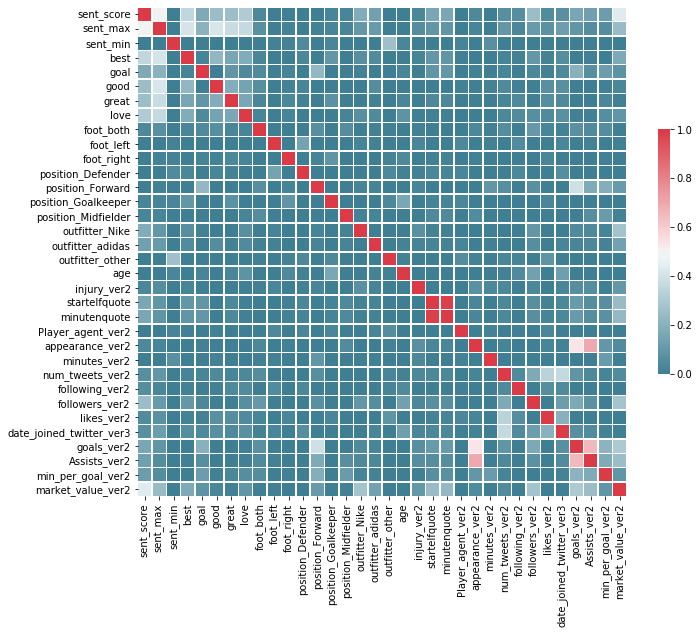

In [26]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,cmap=cmap, vmin=0, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('corr.png', bbox_inches = 'tight')

# modeling

In [146]:
###train test split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 


train_np = final_data

y = train_np[:,-1]


X = train_np[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [149]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [243]:
final.columns[indices]

Index(['nationality_ver2_Oceania', 'followers_ver2',
       'nationality_ver2_North America', 'goals_ver2', 'injury_ver2',
       'Assists_ver2', 'age', 'join_date_ver2', 'nationality_ver2_Europe',
       'appearance_ver2', 'following_ver2', 'nationality_ver2_Africa',
       'height_ver2', 'num_tweets_ver2', 'startelfquote', 'likes_ver2',
       'position_Defender', 'date_joined_twitter_ver3',
       'nationality_ver2_South America', 'sent_score', 'min_per_goal_ver2',
       'minutenquote', 'minutes_ver2', 'sent_max', 'exp_date_ver2',
       'foot_left', 'Player_agent_ver2', 'sent_min', 'nationality_ver2_Asia',
       'foot_both', 'goal', 'outfitter_other', 'position_Forward',
       'foot_right', 'great', 'position_Midfielder', 'good', 'best',
       'outfitter_Nike', 'love', 'outfitter_adidas', 'position_Goalkeeper'],
      dtype='object')

In [244]:
##############regression results

In [155]:
rf_y_pred = regr.predict(X_test)


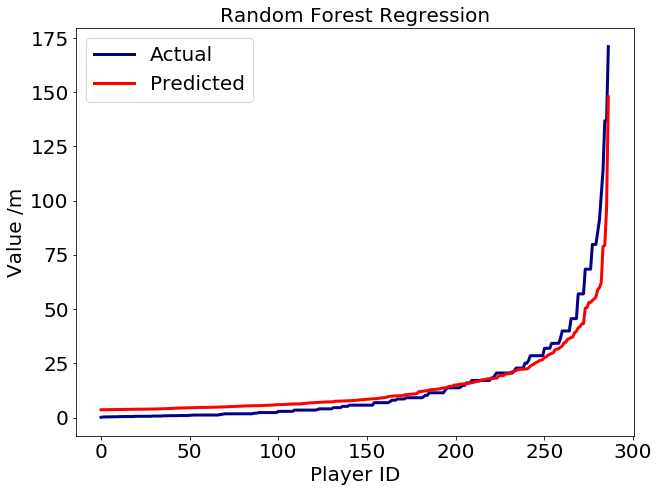

In [157]:
plt.figure(figsize=(10,7.5))
plt.plot(np.sort(y_test),  color='darkblue',linewidth=3, label="Actual")
plt.plot(np.sort(rf_y_pred), color='red', linewidth=3,label="Predicted")
plt.xlabel('Player ID',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Value /m',fontsize = 20)
plt.legend(fontsize = 20)
plt.title('Random Forest Regression',fontsize = 20)
plt.savefig('randomforest_results.png',transparent=True, bbox_inches = 'tight')
plt.show()


In [164]:
from sklearn.metrics import r2_score
rf_r2 = r2_score(y_test, rf_y_pred)


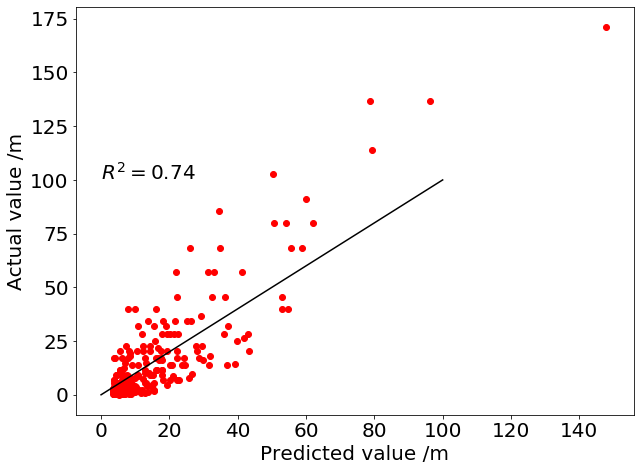

In [167]:
plt.figure(figsize=(10,7.5))
plt.plot([0,100], [0,100], color = 'black')
plt.scatter(rf_y_pred, y_test, color='red')
plt.xlabel('Predicted value /m',fontsize = 20)
plt.ylabel('Actual value /m',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.text(0,100, r'$R^2 = {}$'.format("%.2f" % rf_r2), ha='left', rotation=0, wrap=True, fontsize = 20)


plt.savefig('rf.png',transparent=True, bbox_inches = 'tight')
plt.show()